In [2]:
try:
  import google.colab
  RUNNING_ON_COLAB= True
except:
  RUNNING_ON_COLAB= False

In [3]:
if RUNNING_ON_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  

In [4]:
!ls

data					      Feature_eng.ipynb
diabetes_012_health_indicators_BRFSS2015.csv  plots
eda.ipynb				      SVM_model.ipynb


In [5]:
import os 

In [6]:
USER = os.environ.get('USER')
print(f'Current user: {USER}')

Current user: slavoj


In [7]:
PATH = 'data/diabetes_012_health_indicators_BRFSS2015.csv'

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

import multiprocessing
import time
import mlflow

In [9]:
data = pd.read_csv(PATH)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [11]:
data.dtypes.unique()

array([dtype('float64')], dtype=object)

In [42]:
data.nunique()


Diabetes_012             3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

In [14]:
binary_features = [column for column in data.columns if len(data[column].unique()) == 2]
other_features = [column for column in data.columns if len(data[column].unique()) != 2]
other_features.remove('Diabetes_012')
target_feature = 'Diabetes_012'

In [15]:
print(f'Binary features: \n\t{binary_features}')
print()
print(f'Other features: \n\t{other_features}')
print()
print(f'Target_feature: \n\t{target_feature}')

Binary features: 
	['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Other features: 
	['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Target_feature: 
	Diabetes_012


In [91]:
data_described = data.describe().T.reset_index().rename(columns={'index': 'feature_columns'})

In [92]:
def highlight_feature_types(s):
    if s.feature_columns in binary_features:
        return ['background-color: darkgray'] + ['background-color: white'] * (len(s)-1)
    elif s.feature_columns in other_features:
        return ['background-color: lightgray'] + ['background-color: white'] * (len(s)-1)
    elif s.feature_columns == target_feature:
        return ['background-color: lightgreen'] + ['background-color: white'] * (len(s)-1)
        

In [93]:
data_described.style.apply(highlight_feature_types, axis = 1).format(precision = 4, na_rep='NA',
                            formatter={
                                ('count'):"{:.0f}",
                            }
                            )

#### Binary features

In [94]:
lbf = len(binary_features)
lbf

14

In [95]:
print('-'*80)
for feature in binary_features:
    print(f"Value counts for '{feature}':\n")
    print(f"{data[feature].value_counts().sort_index()}")
    print('-'*80)

--------------------------------------------------------------------------------
Value counts for 'HighBP':

0.0    144851
1.0    108829
Name: HighBP, dtype: int64
--------------------------------------------------------------------------------
Value counts for 'HighChol':

0.0    146089
1.0    107591
Name: HighChol, dtype: int64
--------------------------------------------------------------------------------
Value counts for 'CholCheck':

0.0      9470
1.0    244210
Name: CholCheck, dtype: int64
--------------------------------------------------------------------------------
Value counts for 'Smoker':

0.0    141257
1.0    112423
Name: Smoker, dtype: int64
--------------------------------------------------------------------------------
Value counts for 'Stroke':

0.0    243388
1.0     10292
Name: Stroke, dtype: int64
--------------------------------------------------------------------------------
Value counts for 'HeartDiseaseorAttack':

0.0    229787
1.0     23893
Name: HeartDiseaseo

In [96]:
lbf

14

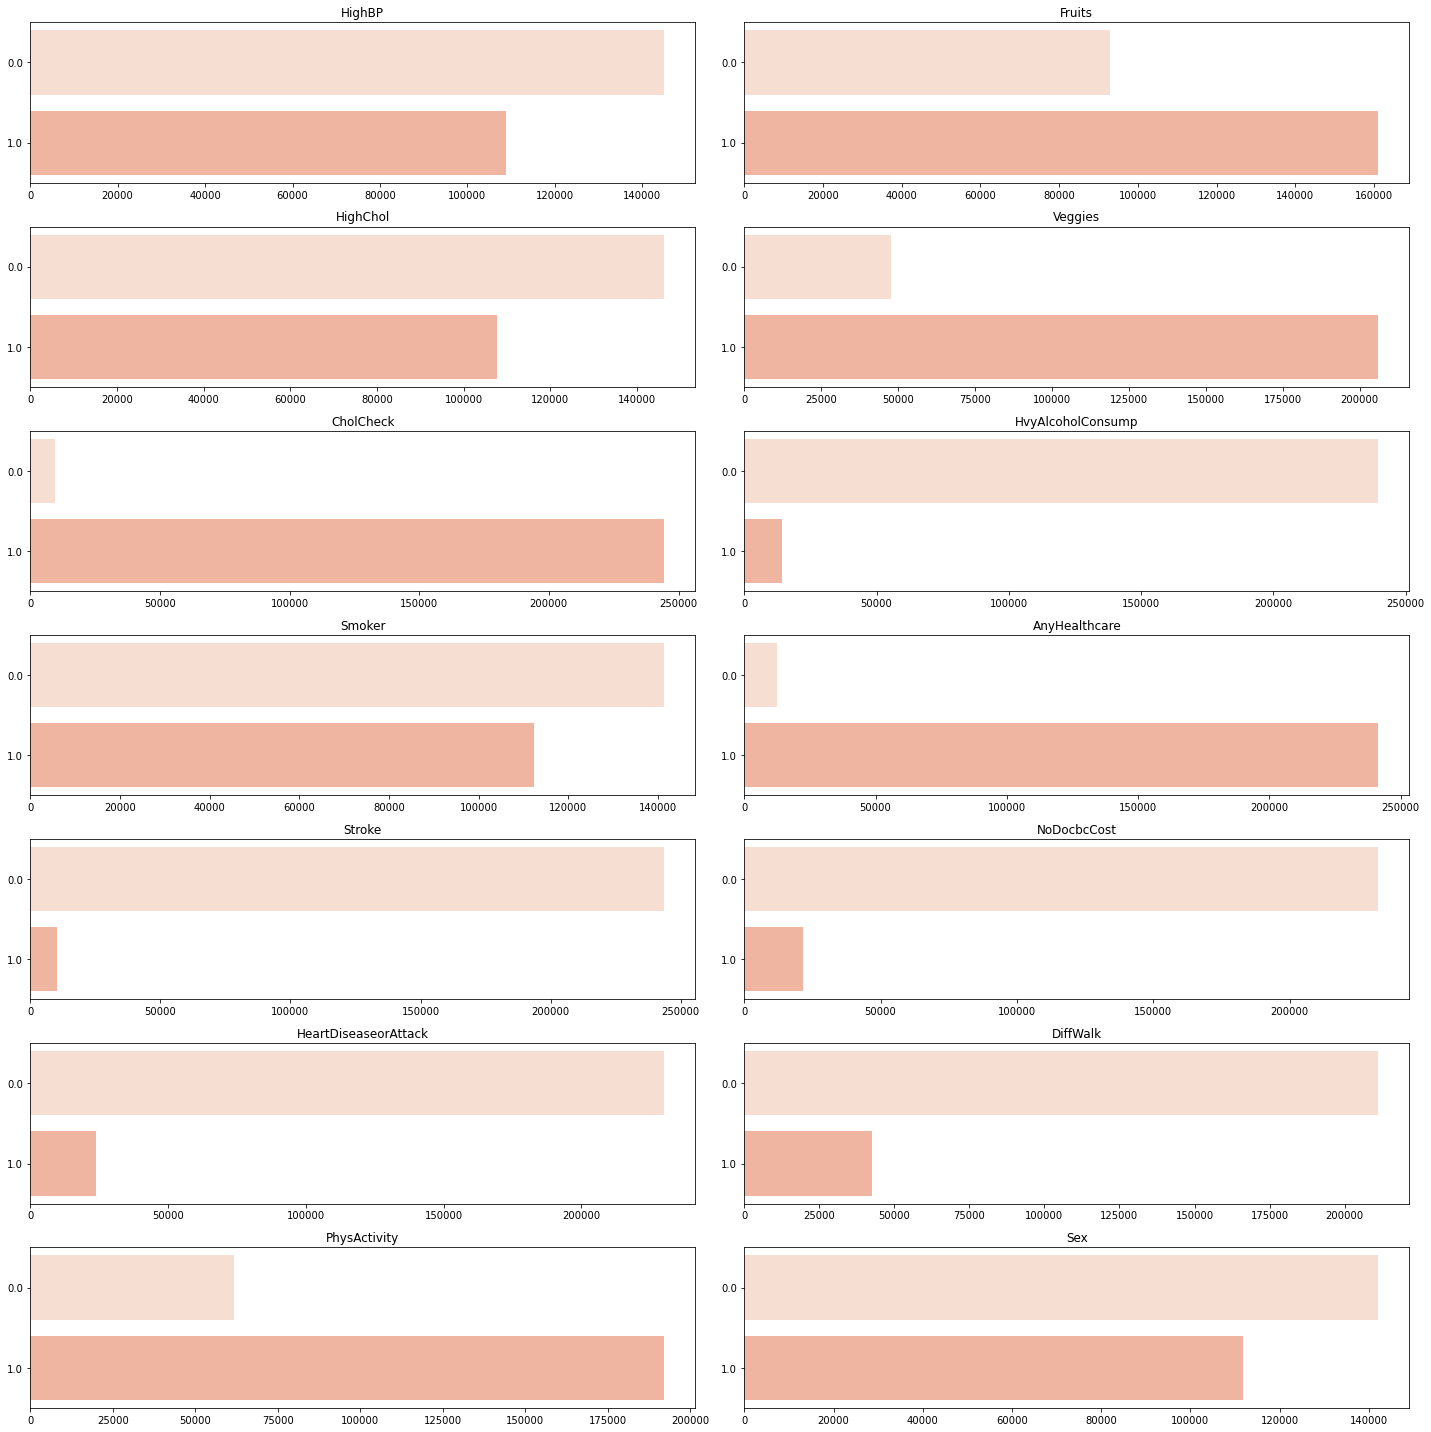

In [97]:
fig, axs = plt.subplots(nrows = 7, ncols = 2, figsize = (20,20))
i, j = 0, 0
sns.set_palette('Reds')
for feature in binary_features:
    if i == lbf / 2:
        i = 0
        j = 1
    subset = data[feature].value_counts()
    x = subset.index
    y = subset.values
    sns.barplot(x = y, y = x, ax = axs[i][j], orient = 'h').set_title(feature)
    i += 1
    
fig.tight_layout()

<AxesSubplot:>

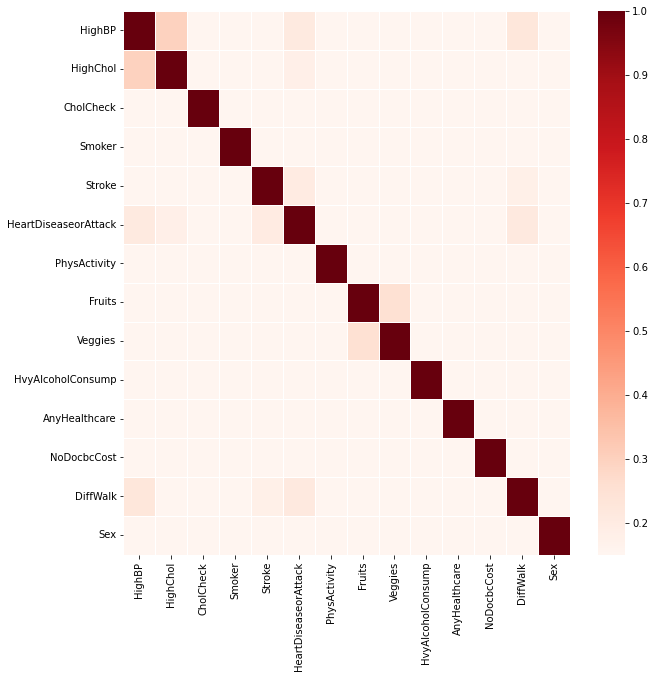

In [98]:
plt.figure(figsize = (10,10))
sns.heatmap(data[binary_features].corr(), vmin = .15, linewidths=1, cmap = 'Reds')


#### Non-binary features

In [99]:
data[other_features]

BMI  GenHlth  MentHlth  PhysHlth   Age  Education  Income
0       40.0      5.0      18.0      15.0   9.0        4.0     3.0
1       25.0      3.0       0.0       0.0   7.0        6.0     1.0
2       28.0      5.0      30.0      30.0   9.0        4.0     8.0
3       27.0      2.0       0.0       0.0  11.0        3.0     6.0
4       24.0      2.0       3.0       0.0  11.0        5.0     4.0
...      ...      ...       ...       ...   ...        ...     ...
253675  45.0      3.0       0.0       5.0   5.0        6.0     7.0
253676  18.0      4.0       0.0       0.0  11.0        2.0     4.0
253677  28.0      1.0       0.0       0.0   2.0        5.0     2.0
253678  23.0      3.0       0.0       0.0   7.0        5.0     1.0
253679  25.0      2.0       0.0       0.0   9.0        6.0     2.0

[253680 rows x 7 columns]

In [100]:
data['BMI']

0         40.0
1         25.0
2         28.0
3         27.0
4         24.0
          ... 
253675    45.0
253676    18.0
253677    28.0
253678    23.0
253679    25.0
Name: BMI, Length: 253680, dtype: float64

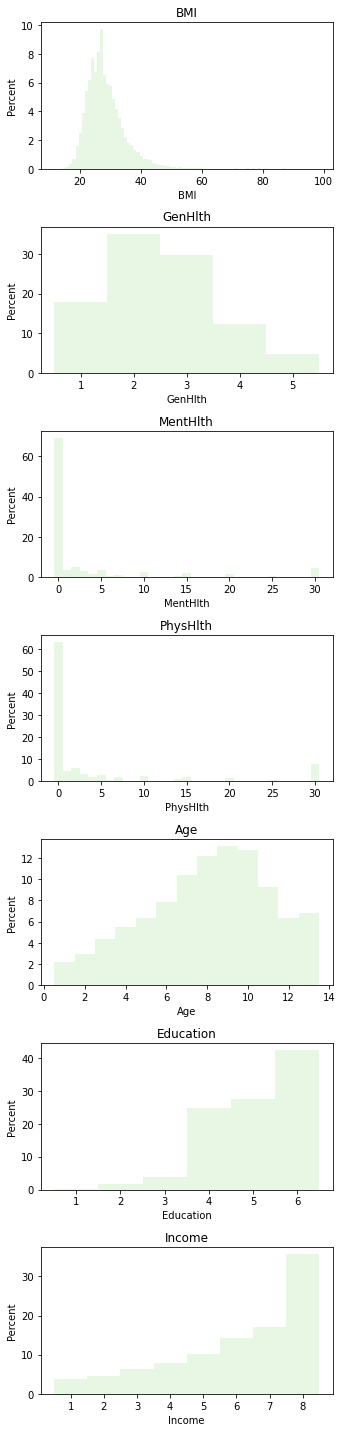

In [120]:
fig, axs = plt.subplots(nrows = 7, figsize = (5,20), sharey = False)
i = 0
sns.set_palette('Greens')
for feature in other_features:
    subset = data[feature]
    sns.histplot(subset, ax = axs[i], fill = True, stat = 'percent', discrete=True, linewidth = 0).set_title(feature)
    i += 1
    
fig.tight_layout()

#### Target feature

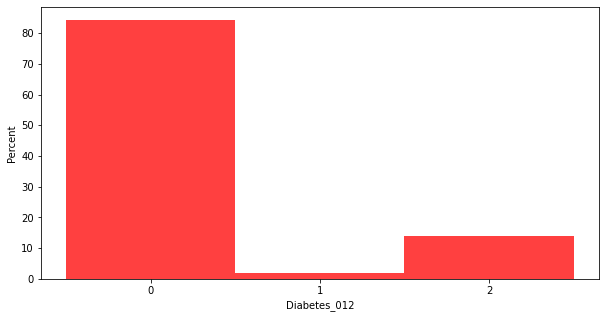

In [123]:
plt.figure(figsize=(10,5))
sns.histplot(data[target_feature], fill = True, color = 'red', stat = 'percent', discrete=True, linewidth = 0)
plt.xticks([0,1,2])
plt.show()

#### Visualizing the data

In [12]:
def dim_reduction(X: np.array, n_dims: int, method: str) -> list:
    """ Dimensionality reduction w/ default parameters """
    start = time.time()
    if method == 'pca':
        pca = PCA(n_components = n_dims)
        pca_result = pca.fit_transform(X)
        
        end = time.time()
        
        print(40*'-')
        print(f"The shape of the reduced array is {pca_result.shape}")
        print(f"Method: {method}")
        print(f"Elapsed time: {end - start} ~ {(end-start)/60} mins")
        print(40*'-')
        print(f"\n")

        return pca_result

    elif method == 'tsne':
        tsne = TSNE(n_components = n_dims, verbose=1)
        tsne_result = tsne.fit_transform(X)

        end = time.time()   

        print(40*'-')
        print(f"The shape of the reduced array is {tsne_result.shape}")
        print(f"Method: {method}")
        print(f"Elapsed time: {end - start} ~ {(end-start)/60} mins")
        print(40*'-')
        print(f"\n")
        
        return tsne_result
    
    elif method == 'umap':
        u = umap.UMAP(n_components = n_dims)
        umap_result = u.fit_transform(X)

        end = time.time()

        print(40*'-')
        print(f"The shape of the reduced array is {umap_result.shape}")
        print(f"Method: {method}")
        print(f"Elapsed time: {end - start} ~ {(end-start)/60} mins")
        print(40*'-')
        print(f"\n")

        return umap_result

    else:
        raise NotImplemented

In [17]:
X, Y = data[binary_features + other_features], data[target_feature]

In [20]:
pca_1 = dim_reduction(X, n_dims = 2, method = 'pca')

----------------------------------------
The shape of the reduced array is (253680, 2)
Method: pca
Elapsed time: 0.965601921081543 ~ 0.016093365351359048 mins
----------------------------------------




In [37]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': False,
 'axes.axisbelow': 'line',
 'axes.labelcolor': 'black',
 'figure.facecolor': (1, 1, 1, 0),
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'text.color': 'black',
 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>,
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': False,
 'image.cmap': 'viridis',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

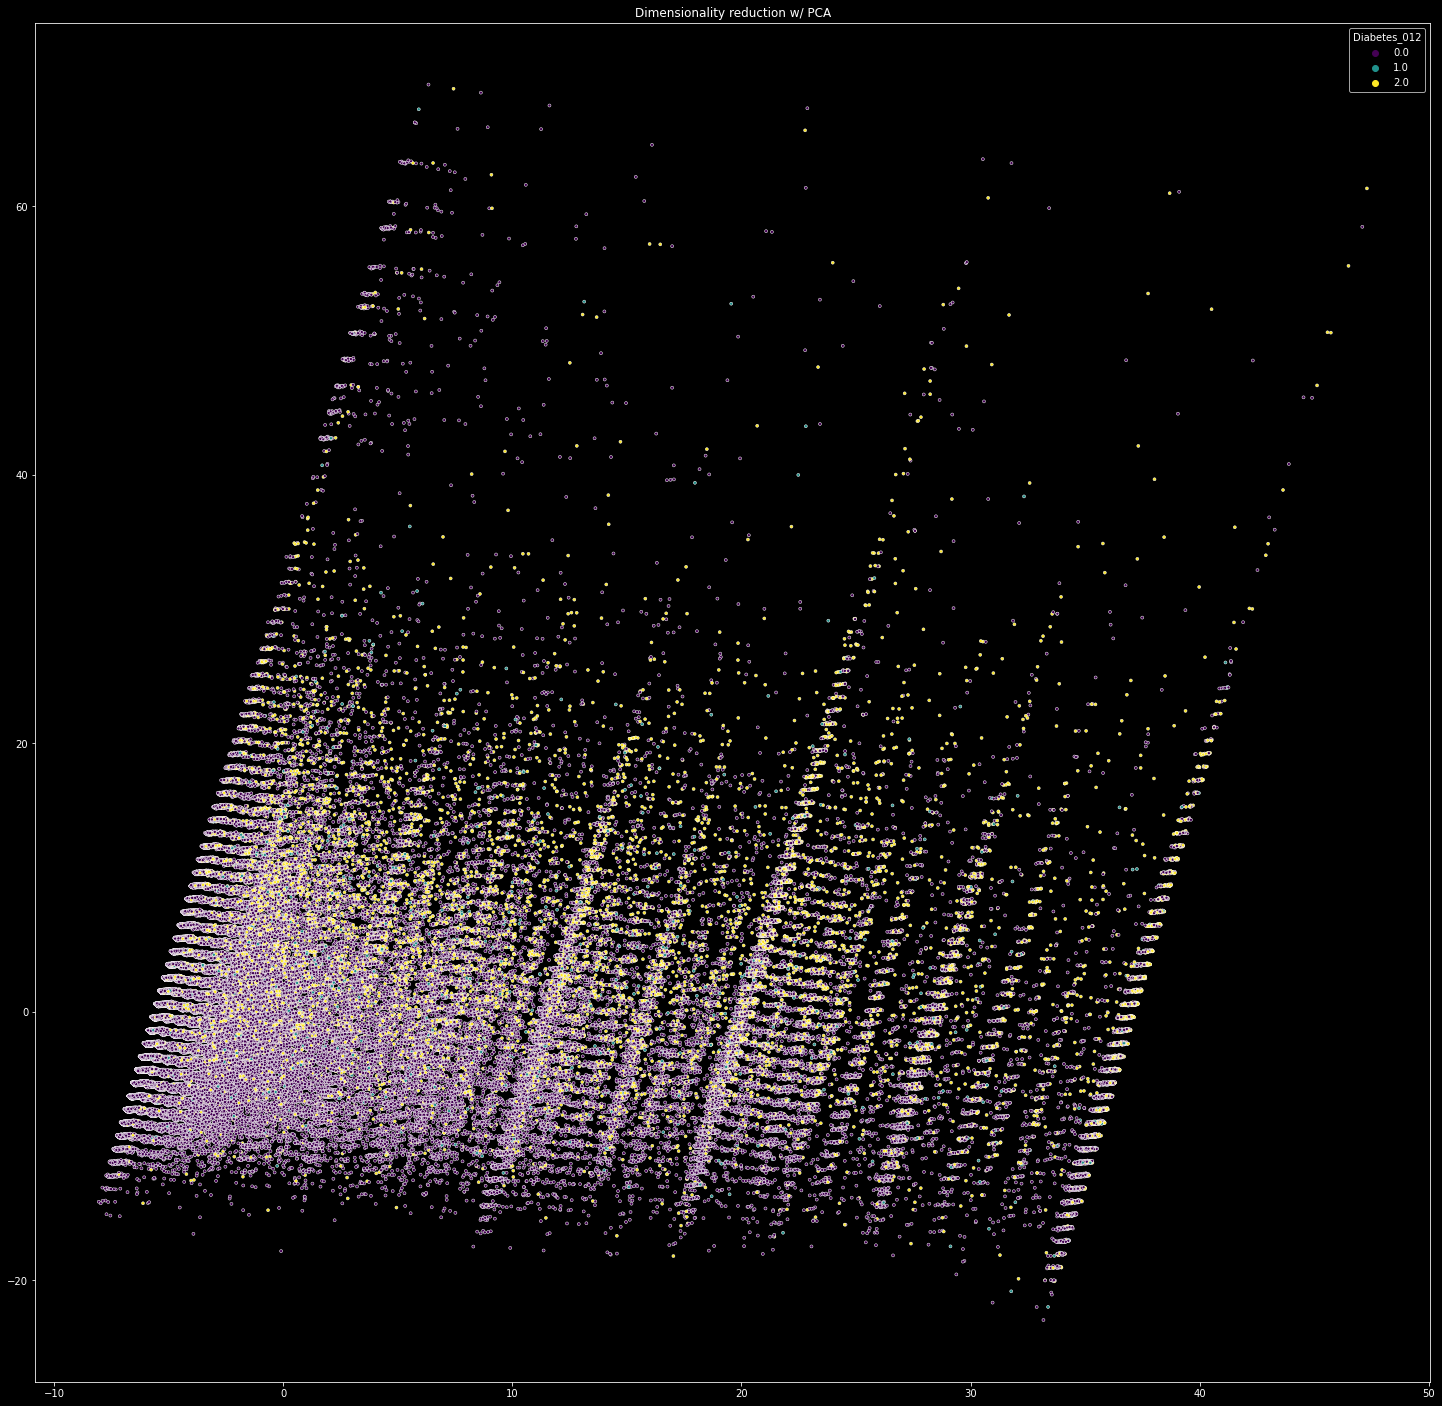

In [47]:
plt.figure(figsize=(25,25))
sns.scatterplot(pca_1[:,0], pca_1[:,1], marker = '.', hue = Y, palette = 'viridis').set_title('Dimensionality reduction w/ PCA')
plt.savefig('plots/dim_red_pca.png')


In [41]:
tsne_1 = dim_reduction(X, n_dims = 2, method = 'tsne')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 253680 samples in 0.006s...
[t-SNE] Computed neighbors for 253680 samples in 1683.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 253680
[t-SNE] Computed conditional probabilities for sample 2000 / 253680
[t-SNE] Computed conditional probabilities for sample 3000 / 253680
[t-SNE] Computed conditional probabilities for sample 4000 / 253680
[t-SNE] Computed conditional probabilities for sample 5000 / 253680
[t-SNE] Computed conditional probabilities for sample 6000 / 253680
[t-SNE] Computed conditional probabilities for sample 7000 / 253680
[t-SNE] Computed conditional probabilities for sample 8000 / 253680
[t-SNE] Computed conditional probabilities for sample 9000 / 253680
[t-SNE] Computed conditional probabilities for sample 10000 / 253680
[t-SNE] Computed conditional probabilities for sample 11000 / 253680
[t-SNE] Computed conditional probabilities for sample 12000 / 253680
[t-SNE] Computed conditional prob

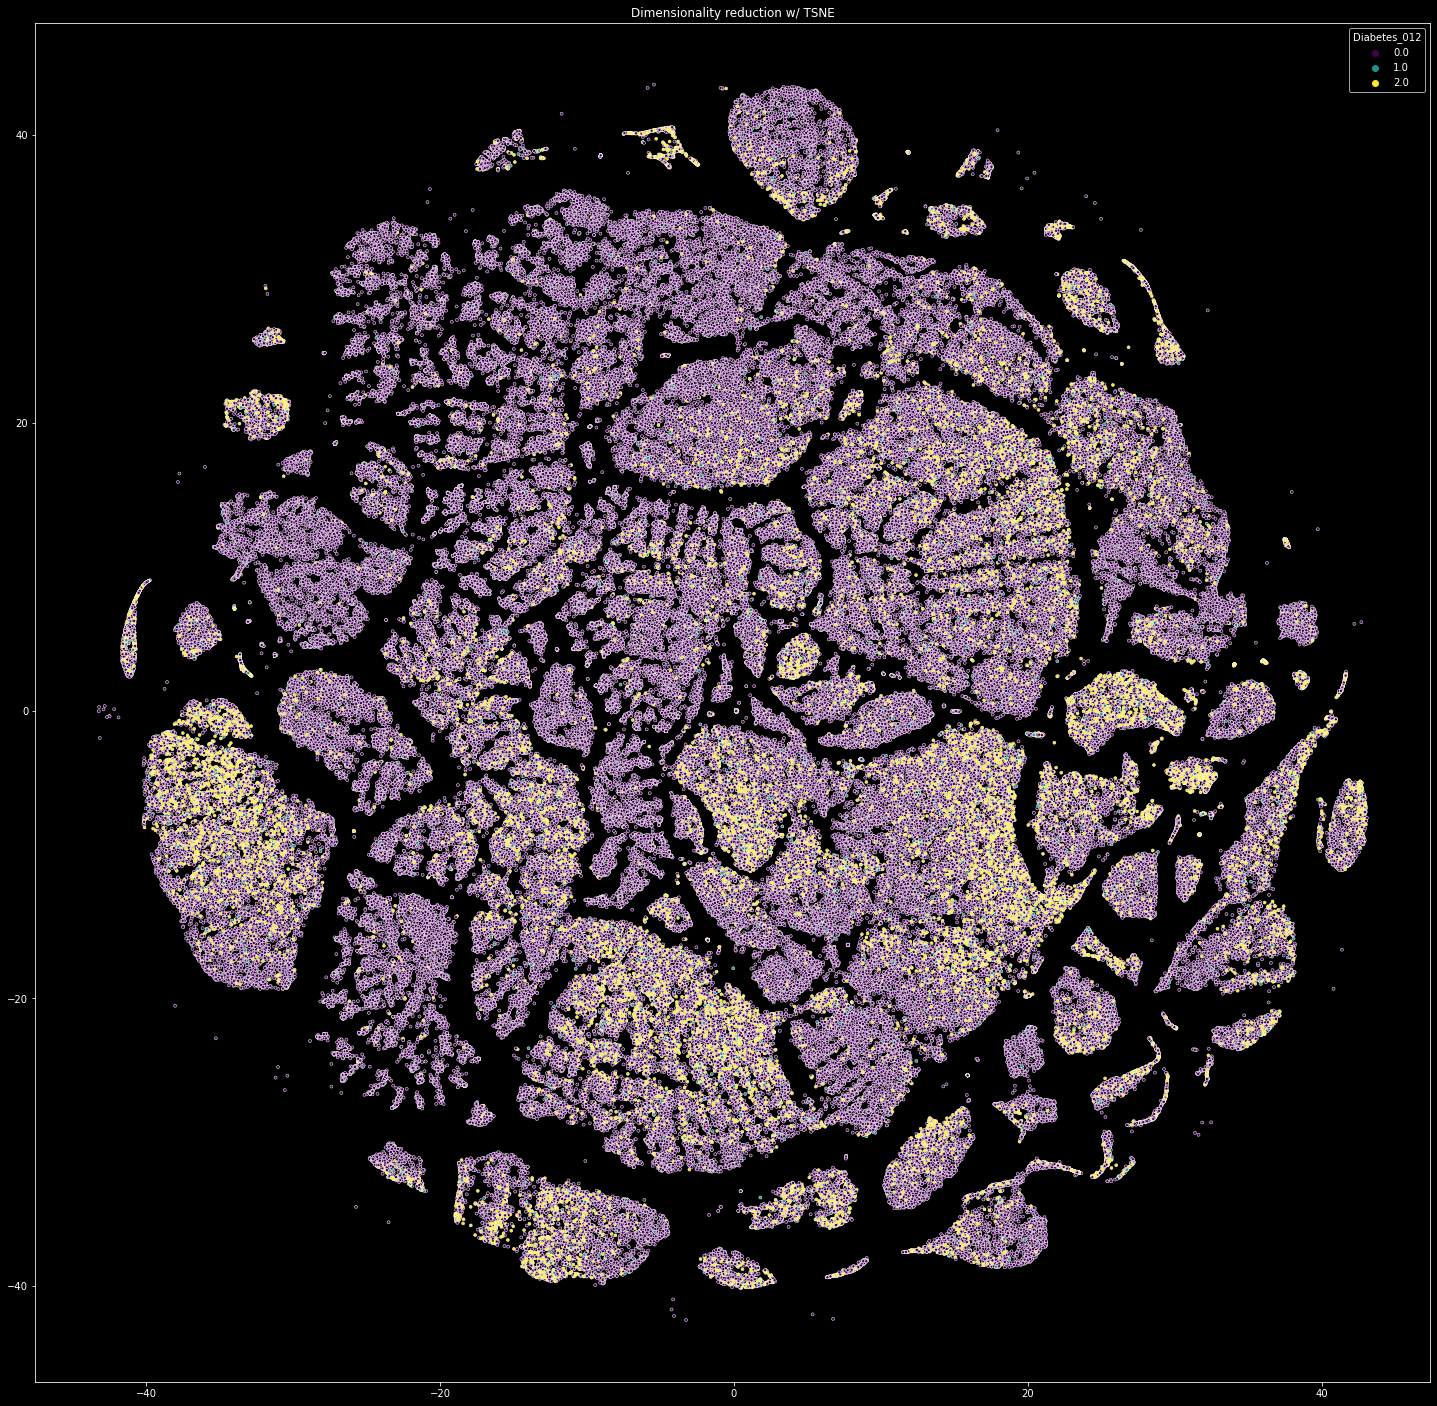

In [46]:
plt.figure(figsize=(25,25))
sns.scatterplot(tsne_1[:,0], tsne_1[:,1], marker = '.', hue = Y, palette = 'viridis').set_title("Dimensionality reduction w/ TSNE")
plt.savefig('plots/dim_red_tsne')

In [48]:
umap_1 = dim_reduction(X, n_dims = 2, method = 'umap')

----------------------------------------
The shape of the reduced array is (253680, 2)
Method: umap
Elapsed time: 165.56875920295715 ~ 2.759479320049286 mins
----------------------------------------




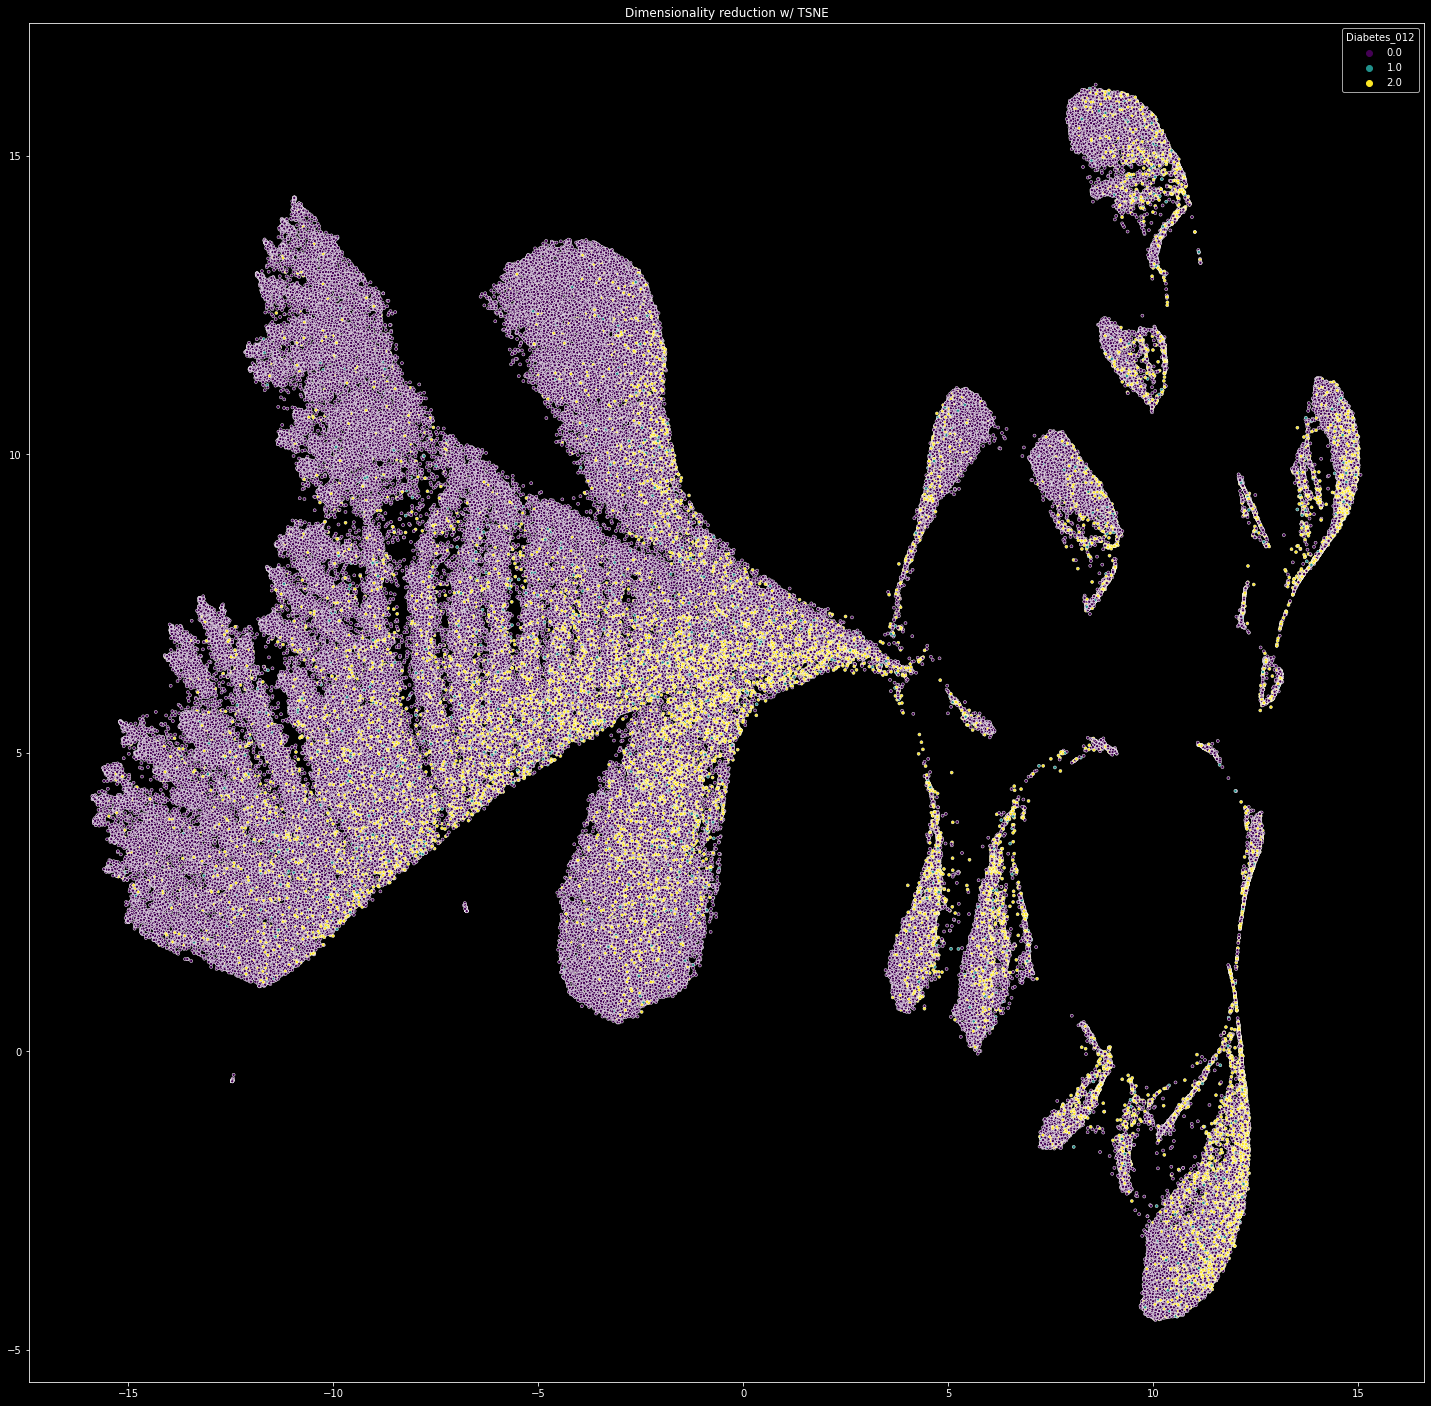

In [49]:
plt.figure(figsize=(25,25))
sns.scatterplot(umap_1[:,0], umap_1[:,1], marker = '.', hue = Y, palette = 'viridis').set_title("Dimensionality reduction w/ TSNE")
plt.savefig('plots/dim_red_umap')

#### Basic models

In [63]:
from sklearn.metrics import f1_score, mean_absolute_error, accuracy_score, matthews_corrcoef, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [103]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 20)

In [59]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, Y_train)

Y_preds = xgb_model.predict(X_test)

[03:07:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
mcc = matthews_corrcoef(y_true = Y_test, y_pred = Y_preds)
mse = mean_squared_error(y_true = Y_test, y_pred = Y_preds)
mae = mean_absolute_error(y_true = Y_test, y_pred = Y_preds)
acc = accuracy_score(y_true = Y_test, y_pred = Y_preds)
f1 = f1_score(y_true = Y_test, y_pred = Y_preds, average='weighted')

In [72]:
print(classification_report(y_true = Y_test, y_pred = Y_preds, target_names = ['0', '1', '2']))

print(f"MAE: \t{mae}")
print(f"MSE: \t{mse}")
print(f"ACC: \t{acc}")
print(f"MCC: \t{mcc}")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.54      0.19      0.28      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.28514269946389154
MSE: 	0.552014348785872
ACC: 	0.8482931251970987
MCC: 	0.2503904187166822


In [ ]:
X_train

In [88]:
fi_xgb = pd.DataFrame( xgb_model.feature_importances_, index = X_train.columns, columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
fi_xgb

f_importance
HighBP                    0.451731
GenHlth                   0.140786
HighChol                  0.076653
CholCheck                 0.047421
HvyAlcoholConsump         0.038008
Age                       0.033073
BMI                       0.029507
HeartDiseaseorAttack      0.025510
DiffWalk                  0.022524
Sex                       0.019640
Income                    0.013912
Stroke                    0.013292
Veggies                   0.010481
Education                 0.010287
PhysHlth                  0.010055
AnyHealthcare             0.009745
Fruits                    0.009736
PhysActivity              0.009519
NoDocbcCost               0.009487
Smoker                    0.009401
MentHlth                  0.009234

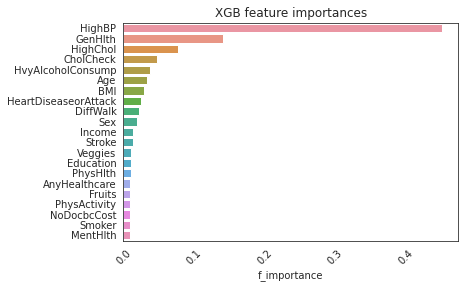

In [95]:
sns.set_style('white')
sns.barplot(y = fi_xgb.index, x = fi_xgb.f_importance).set_title('XGB feature importances')
plt.xticks(rotation = 45)
plt.savefig('plots/xgb_fi')
plt.show()

In [74]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, Y_train)

Y_preds = lgb_model.predict(X_test)

In [75]:
mcc = matthews_corrcoef(y_true = Y_test, y_pred = Y_preds)
mse = mean_squared_error(y_true = Y_test, y_pred = Y_preds)
mae = mean_absolute_error(y_true = Y_test, y_pred = Y_preds)
acc = accuracy_score(y_true = Y_test, y_pred = Y_preds)
f1 = f1_score(y_true = Y_test, y_pred = Y_preds, average='weighted')

In [76]:
print(classification_report(y_true = Y_test, y_pred = Y_preds, target_names = ['0', '1', '2']))

print(f"MAE: \t{mae}")
print(f"MSE: \t{mse}")
print(f"ACC: \t{acc}")
print(f"MCC: \t{mcc}")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42753
           1       0.00      0.00      0.00       927
           2       0.56      0.18      0.27      7056

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736

MAE: 	0.2835856196783349
MSE: 	0.5488804793440555
ACC: 	0.8490618101545254
MCC: 	0.24923258027101233


In [96]:
fi_lgb = pd.DataFrame( lgb_model.feature_importances_, index = X_train.columns, columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
fi_lgb

f_importance
BMI                           1760
Age                           1156
Income                         780
PhysHlth                       718
GenHlth                        711
MentHlth                       654
Education                      544
Sex                            304
HighChol                       289
HighBP                         256
HeartDiseaseorAttack           220
PhysActivity                   201
Smoker                         198
Fruits                         196
Veggies                        179
DiffWalk                       169
NoDocbcCost                    154
CholCheck                      152
HvyAlcoholConsump              146
Stroke                         132
AnyHealthcare                   81

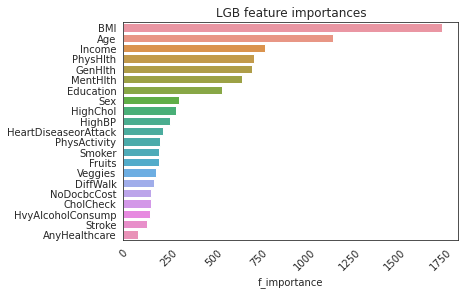

In [97]:
sns.set_style('white')
sns.barplot(y = fi_lgb.index, x = fi_lgb.f_importance).set_title('LGB feature importances')
plt.xticks(rotation = 45)
plt.savefig('plots/lgb_fi')
plt.show()

In [98]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,Y_train)
Y_preds = rf_model.predict(X_test)

In [99]:
mcc = matthews_corrcoef(y_true = Y_test, y_pred = Y_preds)
mse = mean_squared_error(y_true = Y_test, y_pred = Y_preds)
mae = mean_absolute_error(y_true = Y_test, y_pred = Y_preds)
acc = accuracy_score(y_true = Y_test, y_pred = Y_preds)
f1 = f1_score(y_true = Y_test, y_pred = Y_preds, average='weighted')

In [100]:
print(classification_report(y_true = Y_test, y_pred = Y_preds, target_names = ['0', '1', '2']))

print(f"MAE: \t{mae}")
print(f"MSE: \t{mse}")
print(f"ACC: \t{acc}")
print(f"MCC: \t{mcc}")

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42753
           1       0.03      0.00      0.00       927
           2       0.48      0.19      0.28      7056

    accuracy                           0.84     50736
   macro avg       0.46      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736

MAE: 	0.2976387574897509
MSE: 	0.5762969094922737
ACC: 	0.8416903185115105
MCC: 	0.2295780694957116


In [101]:
fi_rf = pd.DataFrame( rf_model.feature_importances_, index = X_train.columns, columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
fi_rf

f_importance
BMI                       0.184655
Age                       0.122352
Income                    0.097978
PhysHlth                  0.084051
GenHlth                   0.070812
Education                 0.068480
MentHlth                  0.064528
HighBP                    0.039515
Smoker                    0.034208
Fruits                    0.033927
Sex                       0.028988
Veggies                   0.027254
HighChol                  0.026308
PhysActivity              0.026297
DiffWalk                  0.024366
HeartDiseaseorAttack      0.017886
NoDocbcCost               0.015418
Stroke                    0.012263
AnyHealthcare             0.008961
HvyAlcoholConsump         0.007898
CholCheck                 0.003855

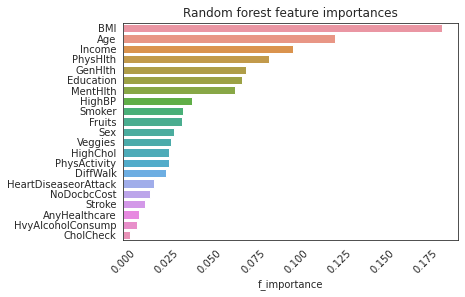

In [102]:
sns.set_style('white')
sns.barplot(y = fi_rf.index, x = fi_rf.f_importance).set_title('Random forest feature importances')
plt.xticks(rotation = 45)
plt.savefig('plots/rf_fi')
plt.show()

In [104]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,Y_train)
Y_preds = decision_tree.predict(X_test)

In [105]:
mcc = matthews_corrcoef(y_true = Y_test, y_pred = Y_preds)
mse = mean_squared_error(y_true = Y_test, y_pred = Y_preds)
mae = mean_absolute_error(y_true = Y_test, y_pred = Y_preds)
acc = accuracy_score(y_true = Y_test, y_pred = Y_preds)
f1 = f1_score(y_true = Y_test, y_pred = Y_preds, average='weighted')

In [106]:
print(classification_report(y_true = Y_test, y_pred = Y_preds, target_names = ['0', '1', '2']))

print(f"MAE: \t{mae}")
print(f"MSE: \t{mse}")
print(f"ACC: \t{acc}")
print(f"MCC: \t{mcc}")

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     42753
           1       0.03      0.04      0.04       927
           2       0.30      0.32      0.31      7056

    accuracy                           0.77     50736
   macro avg       0.40      0.41      0.40     50736
weighted avg       0.78      0.77      0.77     50736

MAE: 	0.4225599180069379
MSE: 	0.8057198044780827
ACC: 	0.7690200252286346
MCC: 	0.1856476093853313


In [107]:
fi_dt = pd.DataFrame(decision_tree.feature_importances_, index = X_train.columns, columns = ['f_importance']).sort_values(by = 'f_importance', ascending=False)
fi_dt

f_importance
BMI                       0.137859
Income                    0.108492
Age                       0.095646
PhysHlth                  0.090115
Education                 0.079221
MentHlth                  0.070610
HighBP                    0.068772
GenHlth                   0.064257
Fruits                    0.036694
Smoker                    0.036634
PhysActivity              0.035346
Veggies                   0.032855
Sex                       0.027739
DiffWalk                  0.023991
HeartDiseaseorAttack      0.020642
NoDocbcCost               0.017281
HighChol                  0.015875
Stroke                    0.015382
AnyHealthcare             0.009732
HvyAlcoholConsump         0.008972
CholCheck                 0.003884

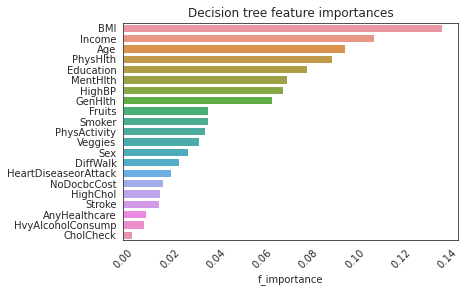

In [108]:
sns.set_style('white')
sns.barplot(y = fi_dt.index, x = fi_dt.f_importance).set_title('Decision tree feature importances')
plt.xticks(rotation = 45)
plt.savefig('plots/dt_fi')
plt.show()